In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from tsmoothie.smoother import ConvolutionSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering as hier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
warnings.filterwarnings('ignore')

import nbimporter
import Functions as Fu


In [2]:
# Φτιαχνω τα objects 

bus1 = Fu.Bus("Sub1act_630.xlsx","Sub1react_630.xlsx")
bus2 = Fu.Bus("Sub2act_630.xlsx","Sub2react_630.xlsx")
bus3 = Fu.Bus("Sub3act_630.xlsx","Sub3react_630.xlsx")

Διάβασμα αρχείων excel και δημιουργία τριών classes Bus

In [3]:
Buses = [bus1,bus2,bus3]
busnames = [('bus1act','bus1react'), ('bus2act','bus2react'), ('bus3act','bus3react')]
powernames = ['real','react']
start = dt.datetime(2018,1,1)
end = dt.datetime(2019,1,1)

#All buses in a dataframe called buses
buses = pd.DataFrame()

for index,bus in enumerate(Buses):
    real = bus.real['Value']
    react = bus.react['Value']

    buses[busnames[index][0]] = real
    buses[busnames[index][1]] = react

# 1. Προεργασία δεδομένων

In [4]:
# Dhmioyrgia dictionary me keys ta columns tou buses kai adeia values opou 8a apothikeusw ta labels
labels_dic = {key: None for key in buses.columns}
filtered_data = {key: None for key in buses.columns}

for key in buses.columns:
    labels_dic[key] = Fu.visualization(buses[key], days=365, n_components=12, title = key)
    
#Αντικατάσταση extreme points με βαση zscore ανα ωρα και ξανά οπτικοποίηση τους
for key in buses.columns:
    filtered_data[key] = Fu.without_extreme_outliers(data = buses[key], labels=labels_dic[key])
    
#Αντικατάσταση πραγματικών τιμών με  filtered_data   
for key in buses.columns:    
    buses[key] = filtered_data[key].reshape(-1).round(2)
for index,bus in enumerate(Buses):
    bus.real['Value'] = buses[busnames[index][0]]
    bus.react['Value'] = buses[busnames[index][1]]

# 2.1 Generating ανά εποχή με gmm μονο: 
1) Χωρισμός σε εργάσιμες και ΣΚ 2) Clustering ξεχωριστά για ΣΚ και Εργασ. 3) Σειριακή συνθήκη ανά μέρα και με βάση το cluster που ανήκει η αντίστοιχη ημέρα, δημιουργώ ένα sample ξεχωριστά το οποίο και χρησιμοποιώ

In [5]:
index = pd.date_range(start=start, end=end, freq='15min', closed='left')
genbuses_2_1 = pd.DataFrame(index = index)

seasons = ['winter','spring','summer','fall']
Months = {}


for index,bus in enumerate(Buses):
    for index2,power in enumerate(powernames):
        
        #Για καθε εποχη κανω GMM δειγαμτοληψια, 5clusters για καθημερινες, 2 για ΣΚ, απο 200 δειγματα για ΣΚ και WD αντιστοιχα 
        for season in seasons:    
            data, months = bus.season(season=season, power=power)
            Year2_1 = Fu.generate_season_2_1(data=data, season=season, months=months, dict_months=Months)
        #Ενωνω τους μηνες απο το dict months 
        months = np.arange(12)+1
        year = Fu.concatinate_season(Months, months)
        data = year.reshape(-1).tolist()
        
        genbuses_2_1[busnames[index][index2]] = data
        
for column in genbuses_2_1.columns:
    if min(genbuses_2_1[column])<=0:
        days = Fu.unique([(i.day,i.month) for i in pd.DataFrame(genbuses_2_1[column].loc[genbuses_2_1[column]<=0]).index])
        for j in days:
            minimum = min(genbuses_2_1[column].loc[(genbuses_2_1.index.day==j[0]) & (genbuses_2_1.index.month==j[1])])
            genbuses_2_1[column].loc[(genbuses_2_1.index.day==j[0]) & (genbuses_2_1.index.month==j[1])] += abs(minimum)

# 2.2 Generating ανά εποχή με gmm και Markov chains: 
1) Χωρισμός σε εργάσιμες και ΣΚ. 2) Χωρισμός σε clusters και Markov chain ανάλυση πραγματικών δεδομένων 4) 150 samples ανά cluster 5) Με βάση τον transition matrix πίνακα εξομοίωση μιας ολόκληρης εποχής 6) Απ τα samples που δημιουργήθηκαν, επιλογή με βάση την εξομοίωση

In [6]:
index = pd.date_range(start=start, end=end, freq='15min', closed='left')
genbuses_2_2 = pd.DataFrame(index = index)

seasons = ['winter','spring','summer','fall']
Months = {}

for index,bus in enumerate(Buses):
    for index2,power in enumerate(powernames):
        
        #Για καθε εποχη κανω GMM δειγαμτοληψια, 5clusters για καθημερινες, 2 για ΣΚ, απο 200 δειγματα για ΣΚ και WD αντιστοιχα 
        for season in seasons:    
            data, months = bus.season(season=season, power=power)
            Year2_2 = Fu.generate_season_2_2(data=data, season=season, months=months, dict_months=Months)
        #Ενωνω τους μηνες απο το dict months 
        months = np.arange(12)+1
        year = Fu.concatinate_season(Months, months)
        data = year.reshape(-1).tolist()
        
        genbuses_2_2[busnames[index][index2]] = data

for column in genbuses_2_2.columns:
    if min(genbuses_2_2[column])<=0:
        days = Fu.unique([(i.day,i.month) for i in pd.DataFrame(genbuses_2_2[column].loc[genbuses_2_2[column]<=0]).index])
        for j in days:
            minimum = min(genbuses_2_2[column].loc[(genbuses_2_2.index.day==j[0]) & (genbuses_2_2.index.month==j[1])])
            genbuses_2_2[column].loc[(genbuses_2_2.index.day==j[0]) & (genbuses_2_2.index.month==j[1])] += abs(minimum)

# 2.3 Generating με αποσυνθεση

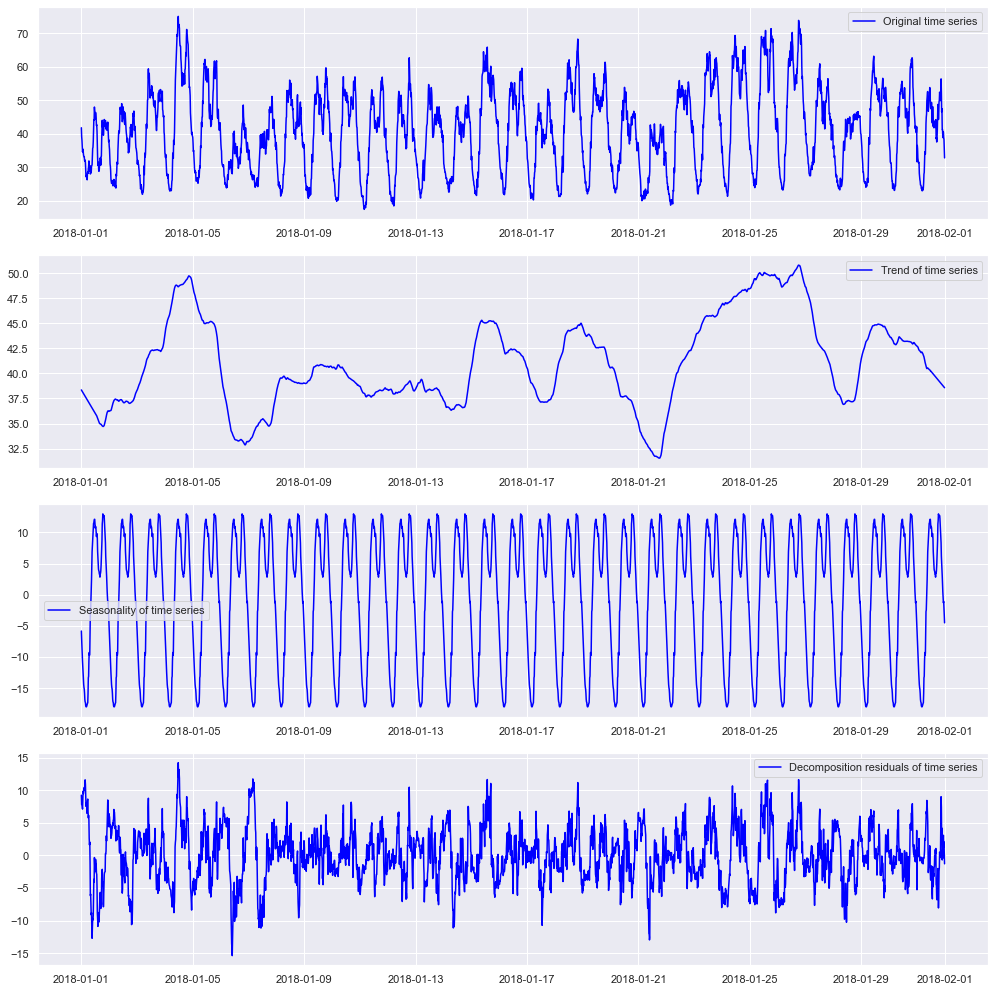

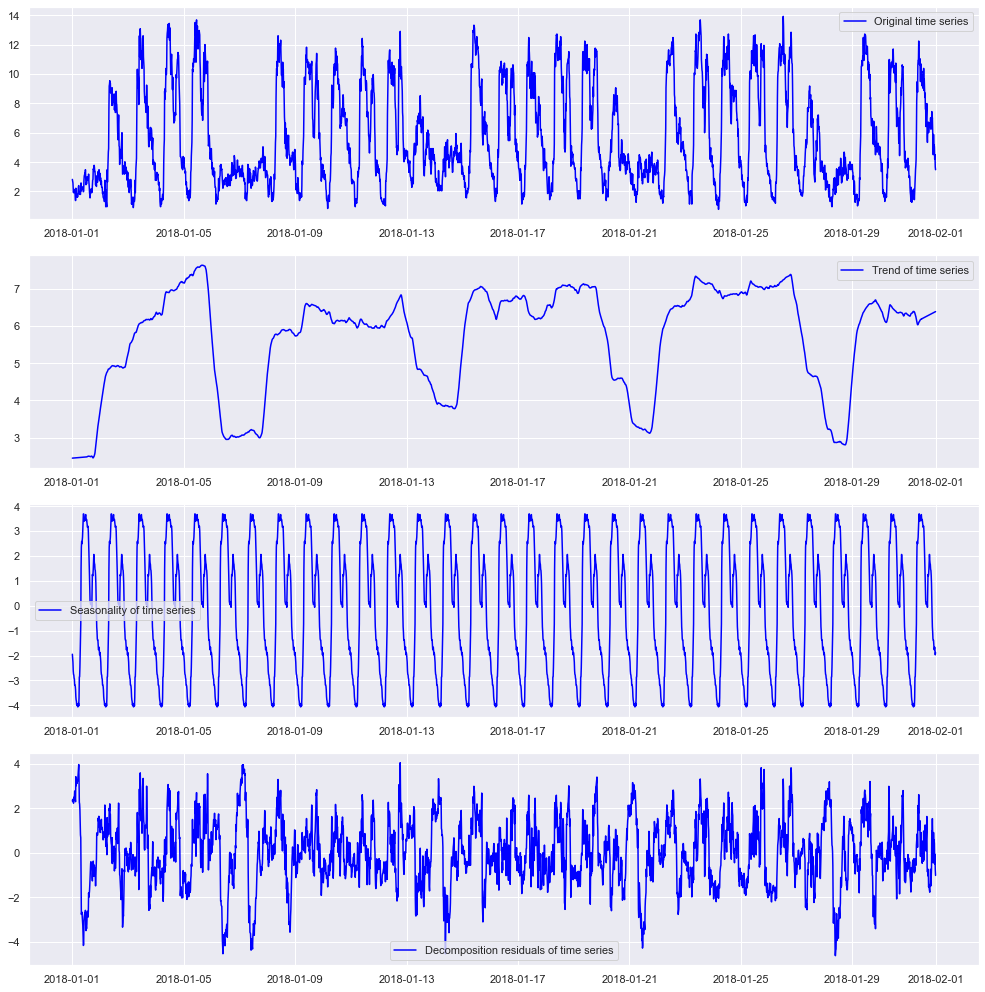

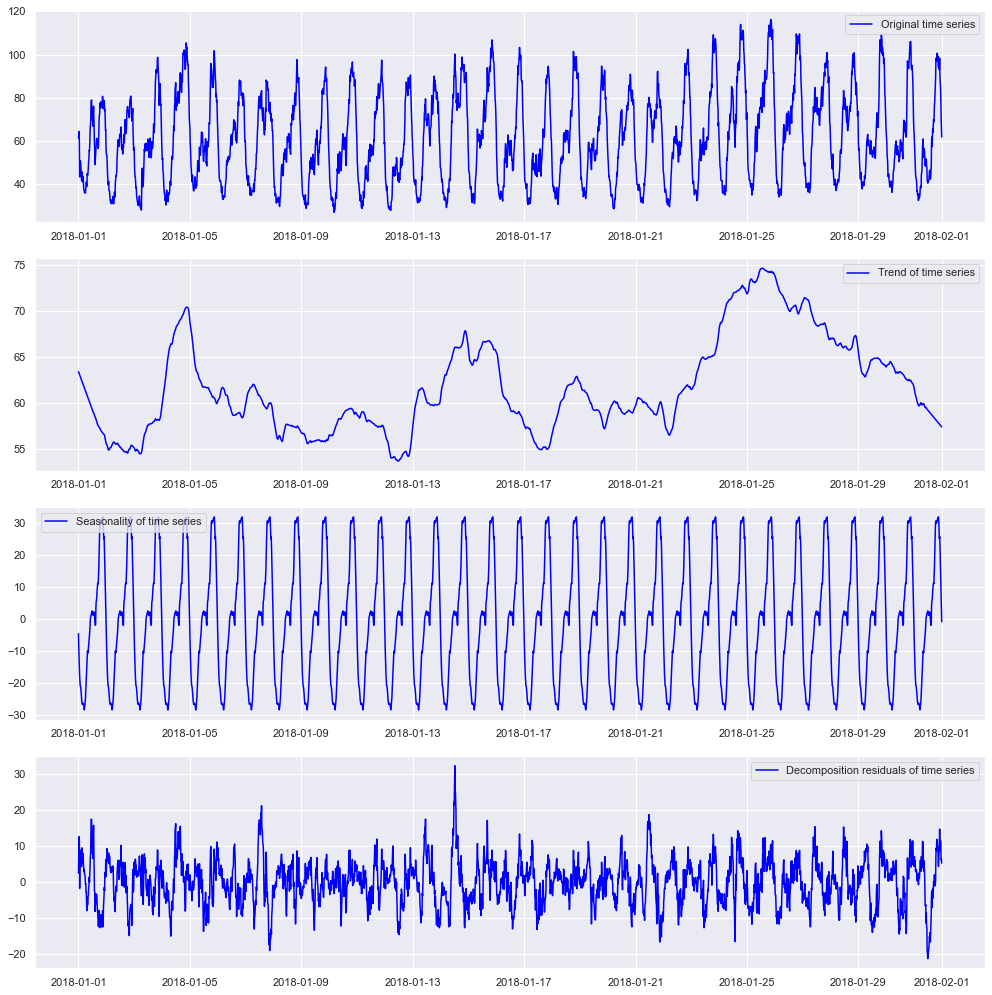

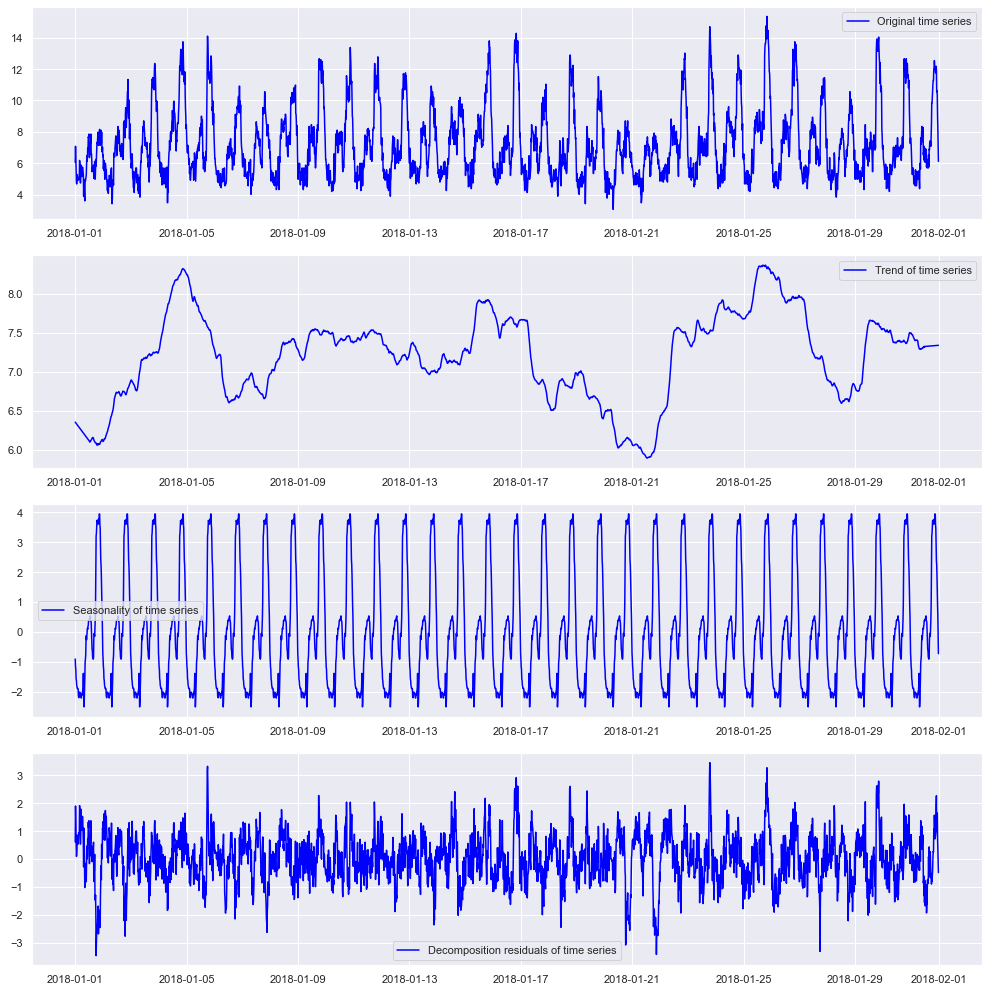

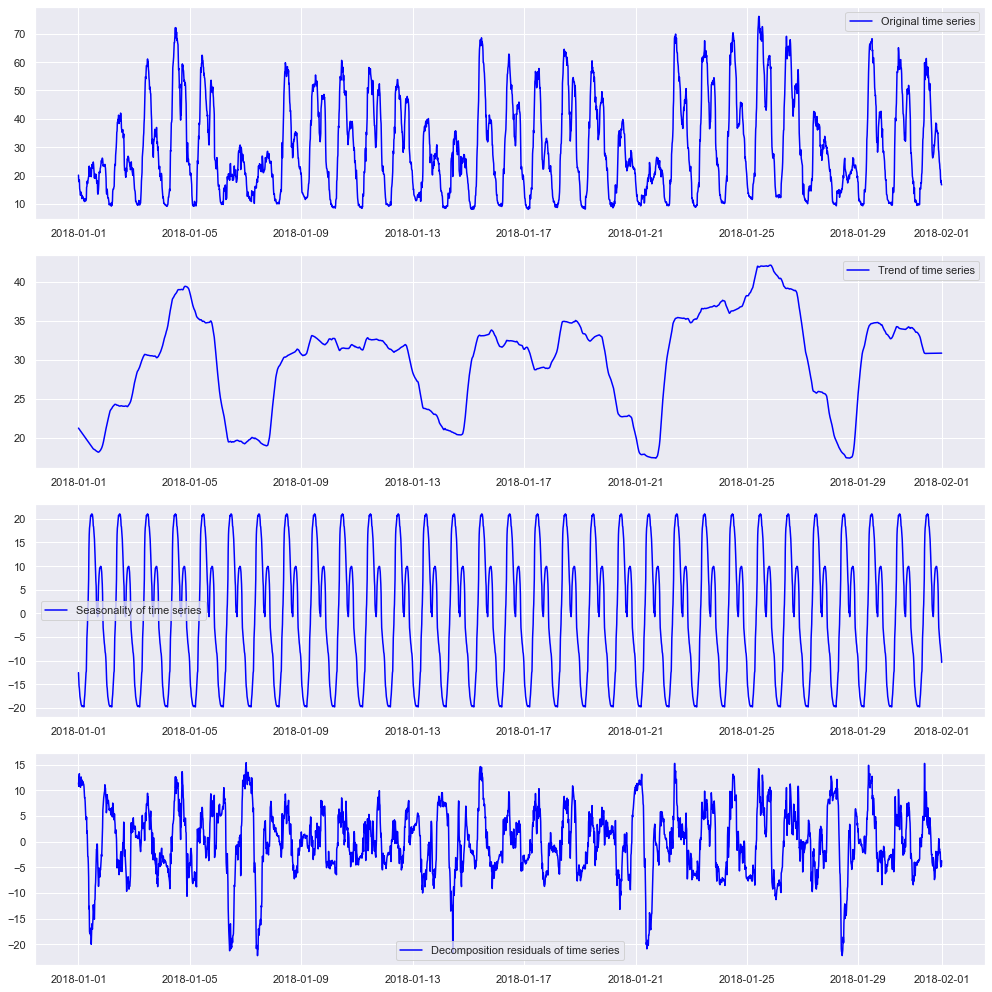

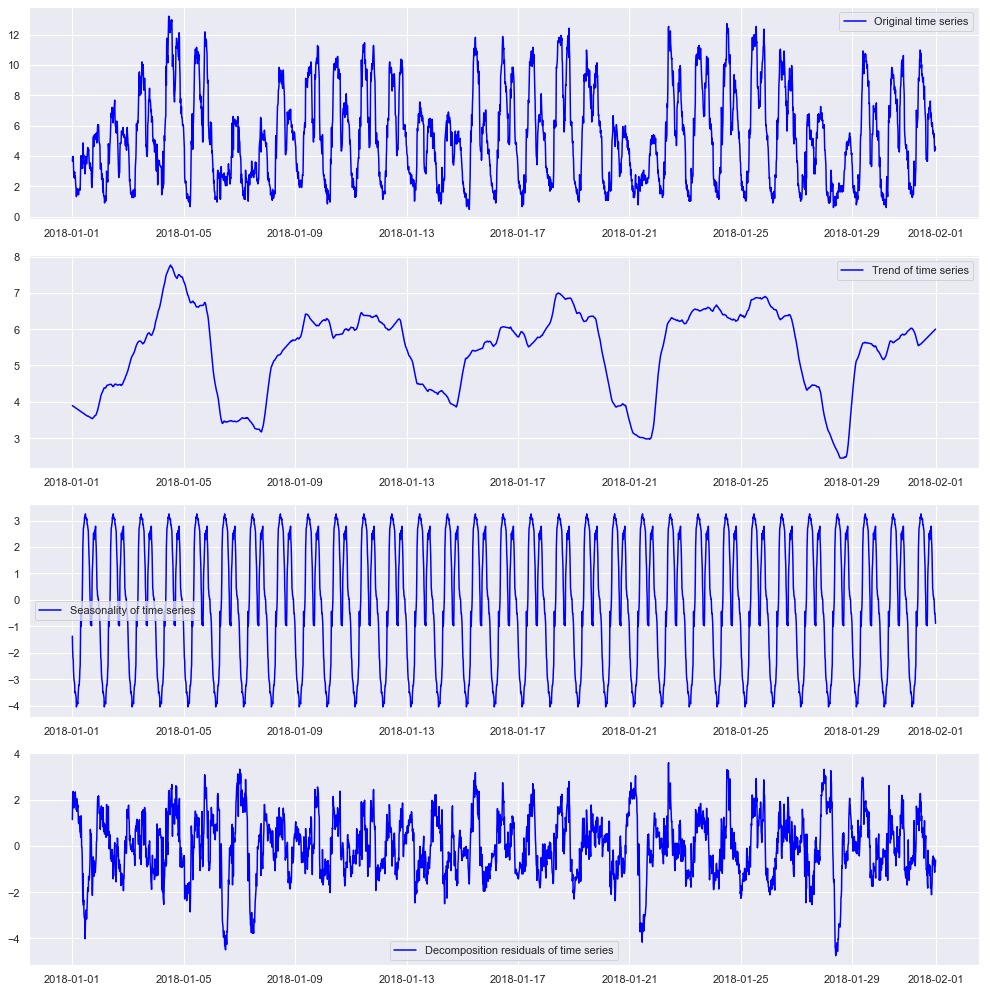

In [7]:
index = pd.date_range(start=start, end=end, freq='15min', closed='left')
genbuses_2_3 = pd.DataFrame(index = index)

for index,bus in enumerate(Buses):
    for index2,power in enumerate(powernames):
        gen = Fu.generate_year_2_3(bus=bus, power=power, period=96)   
        genbuses_2_3[busnames[index][index2]] = gen['Value'].round(2);

In [9]:
#correct dictionary for negative values
for column in genbuses_2_3.columns:
    if min(genbuses_2_3[column])<0:
        days = Fu.unique([(i.day,i.month) for i in pd.DataFrame(genbuses_2_3[column].loc[genbuses_2_3[column]<0]).index])
        for j in days:
            minimum = min(genbuses_2_3[column].loc[(genbuses_2_3.index.day==j[0]) & (genbuses_2_3.index.month==j[1])])
            genbuses_2_3[column].loc[(genbuses_2_3.index.day==j[0]) & (genbuses_2_3.index.month==j[1])] += abs(minimum)
genbuses_2_3

bus1act  bus1react  bus2act  bus2react  bus3act  \
2018-01-01 00:00:00    30.74       2.53    57.30       5.92    10.89   
2018-01-01 00:15:00    29.17       2.42    53.91       5.08     9.85   
2018-01-01 00:30:00    27.28       1.71    54.74       4.95     9.88   
2018-01-01 00:45:00    25.15       1.54    50.94       4.71    10.76   
2018-01-01 01:00:00    23.66       1.49    48.01       4.59     9.77   
...                      ...        ...      ...        ...      ...   
2018-12-31 22:45:00    54.10       5.38    75.14       6.84    22.96   
2018-12-31 23:00:00    53.67       4.19    73.94       5.93    23.71   
2018-12-31 23:15:00    51.01       4.09    69.49       5.57    21.49   
2018-12-31 23:30:00    52.59       3.93    63.41       4.85    22.09   
2018-12-31 23:45:00    49.67       5.08    57.79       4.74    21.26   

                     bus3react  
2018-01-01 00:00:00       1.99  
2018-01-01 00:15:00       2.03  
2018-01-01 00:30:00       1.88  
2018-01-01 00:45:00       1.63  
2018-01-01 01:00:00       1.85  
...                        ...  
2018-12-31 22:45:00       2.48  
2018-12-31 23:00:00       2.41  
2018-12-31 23:15:00       2.87  
2018-12-31 23:30:00       2.85  
2018-12-31 23:45:00       2.65  

[35040 rows x 6 columns]

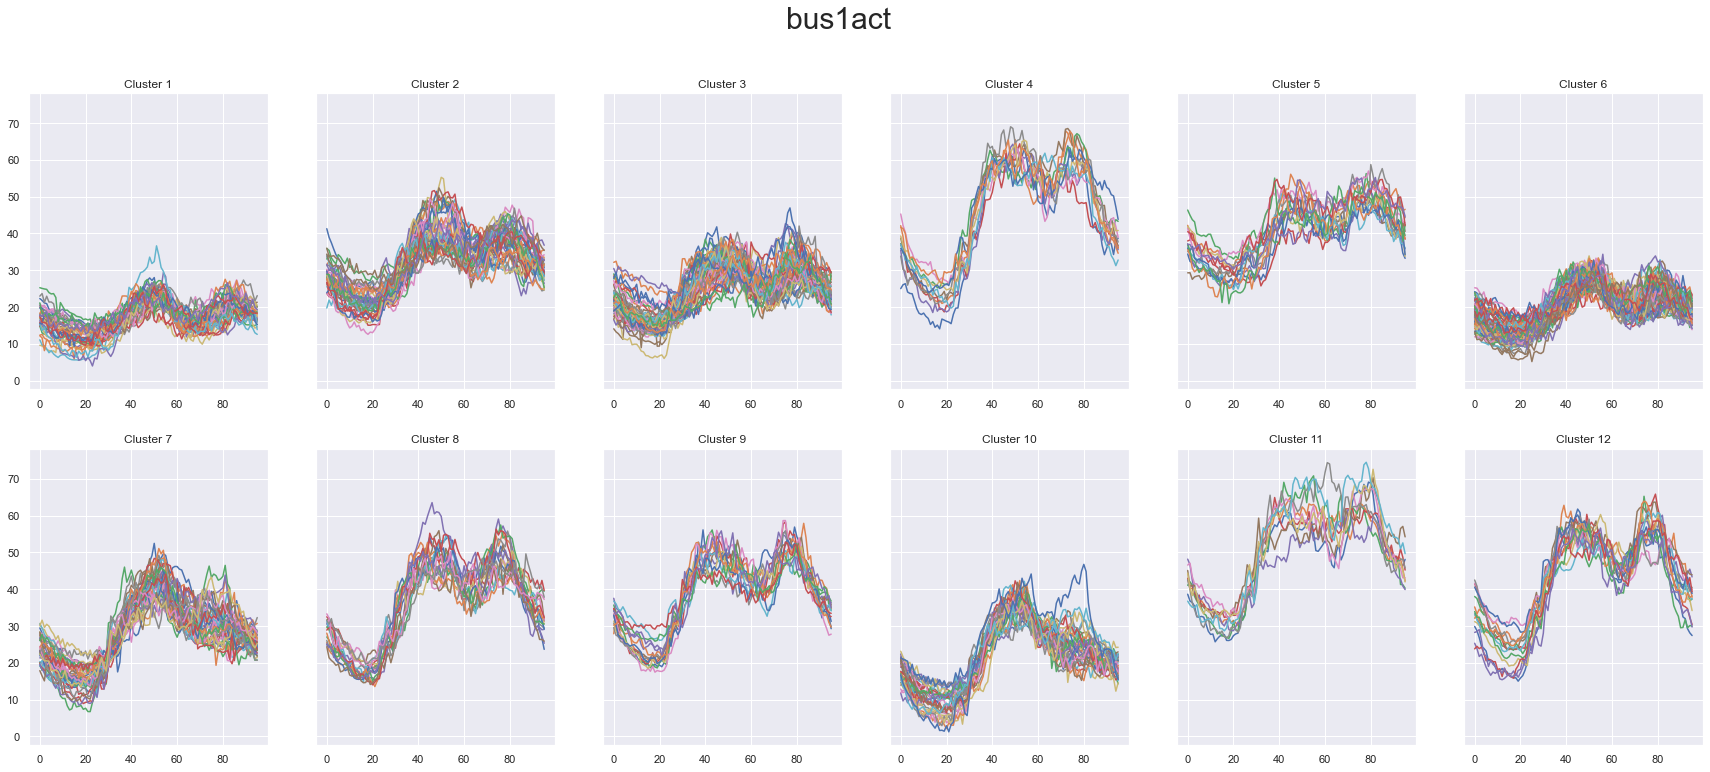

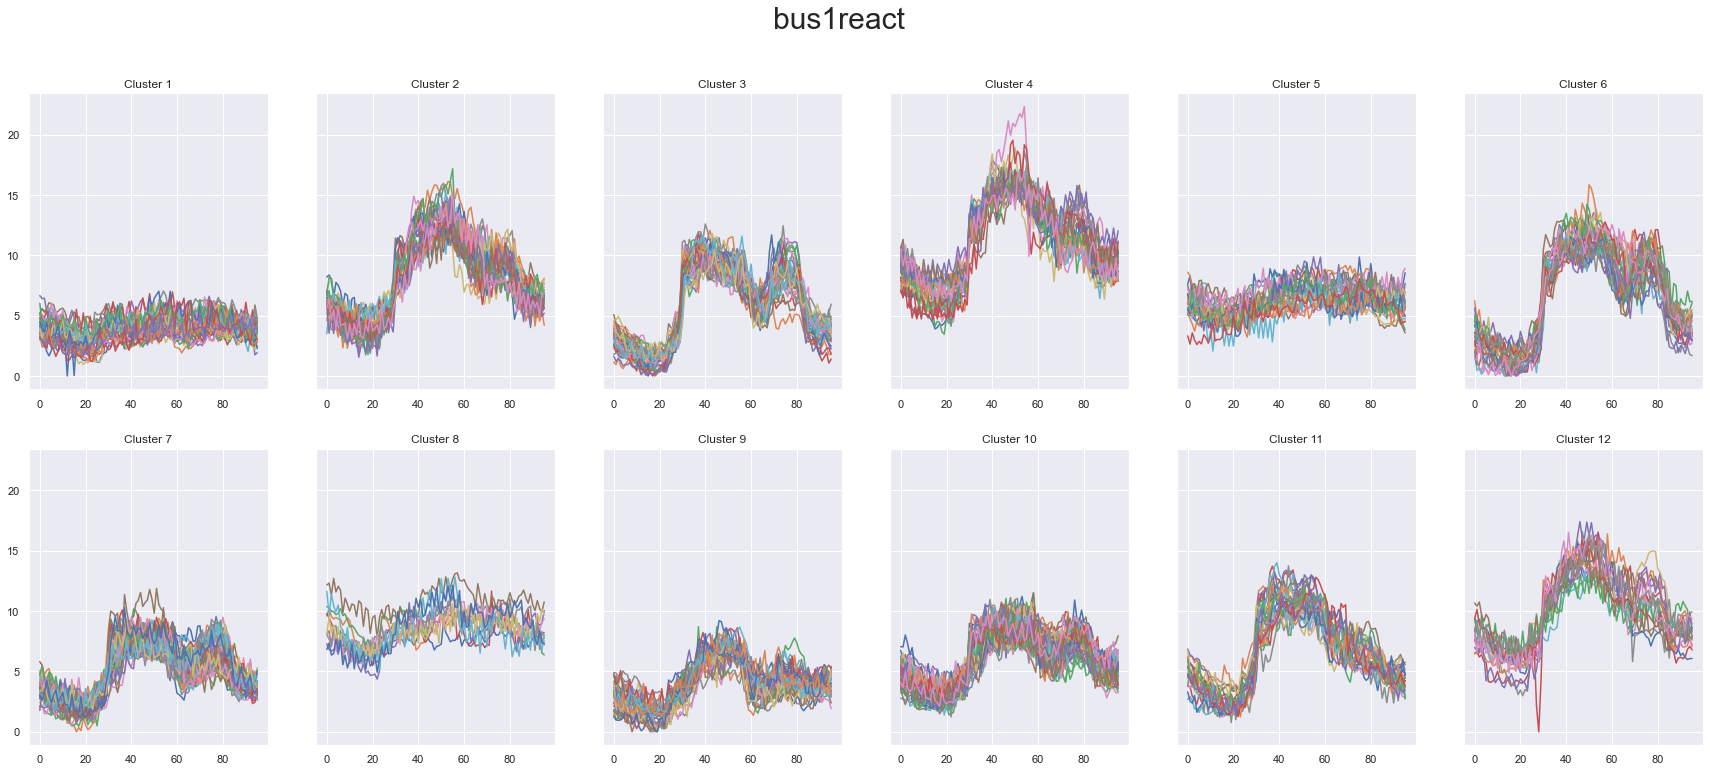

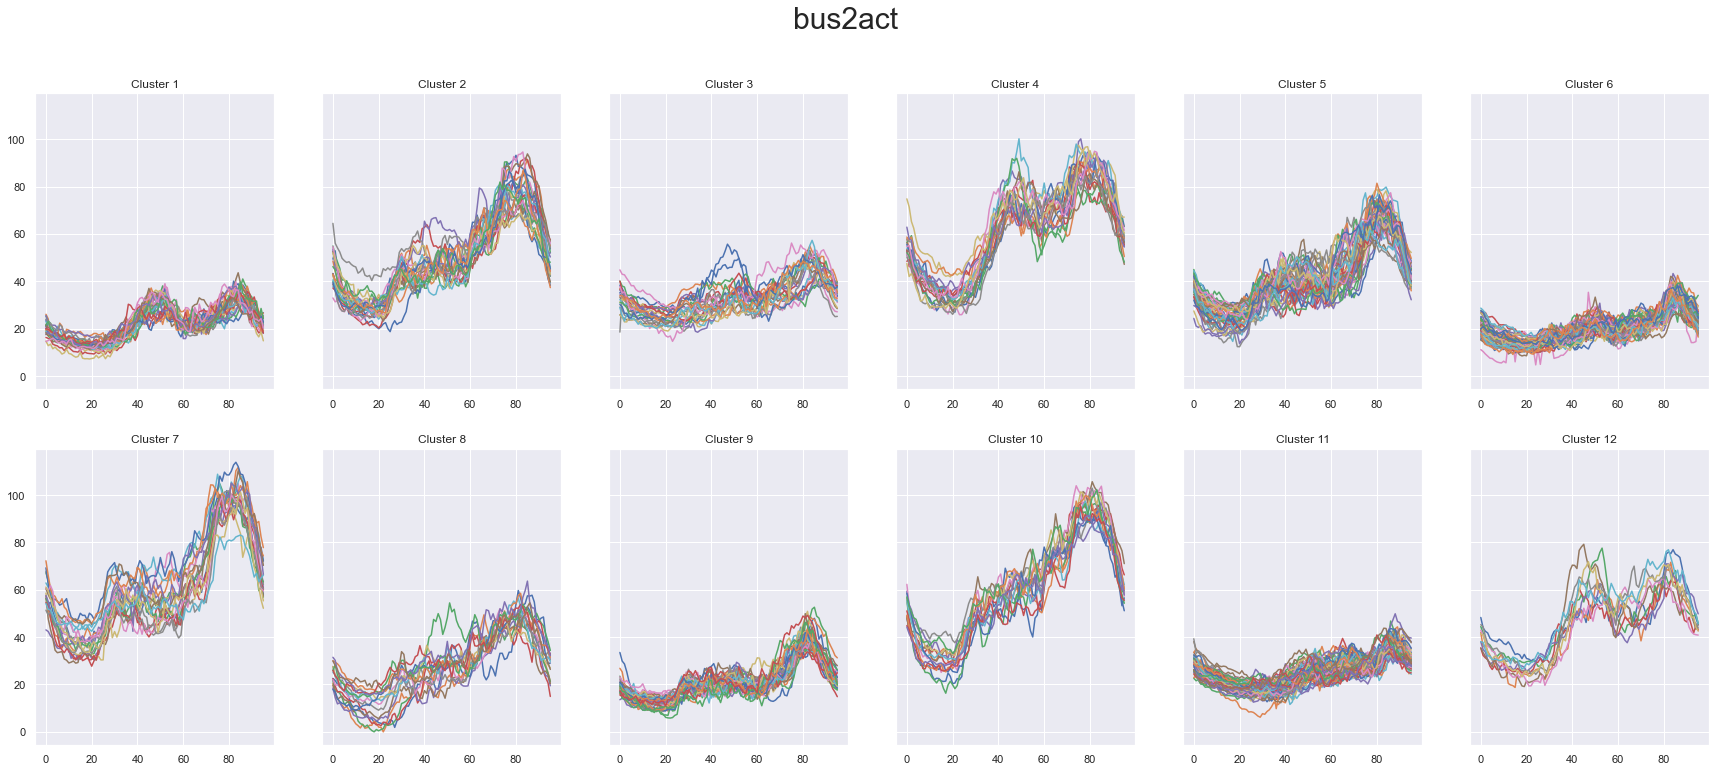

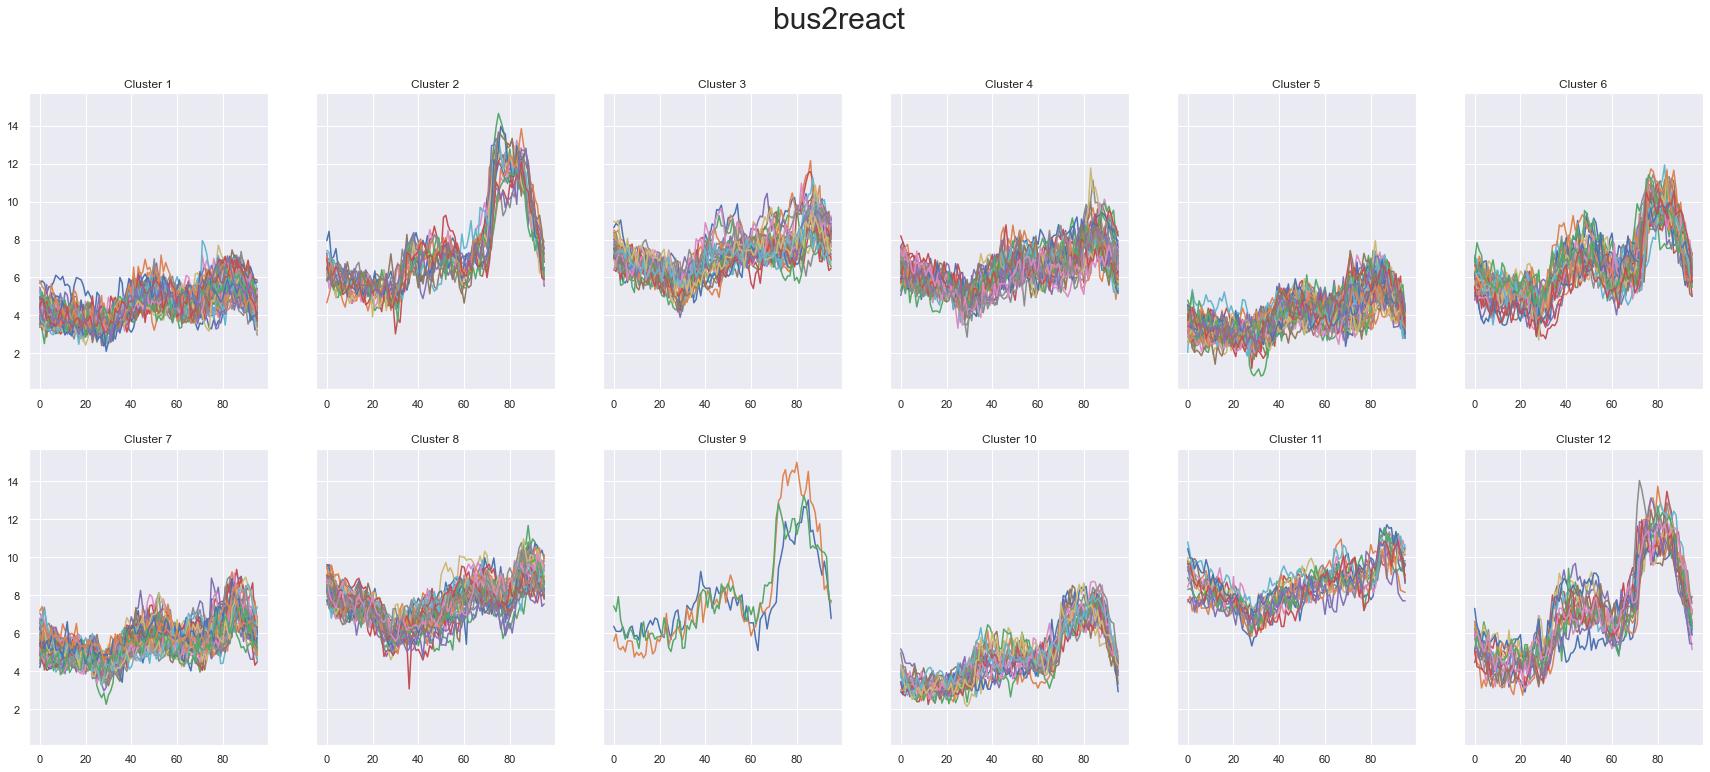

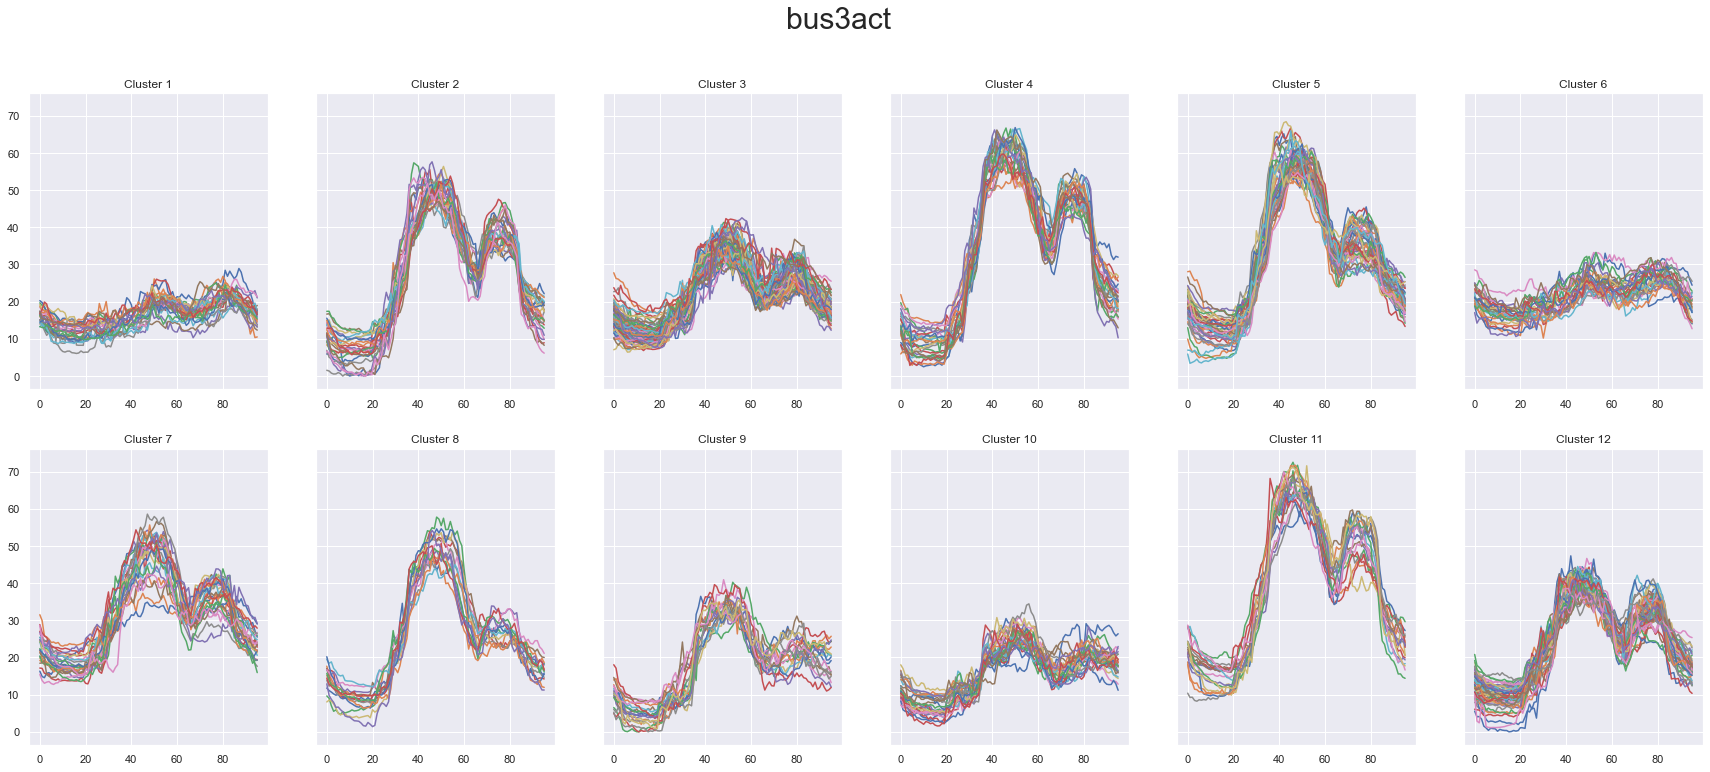

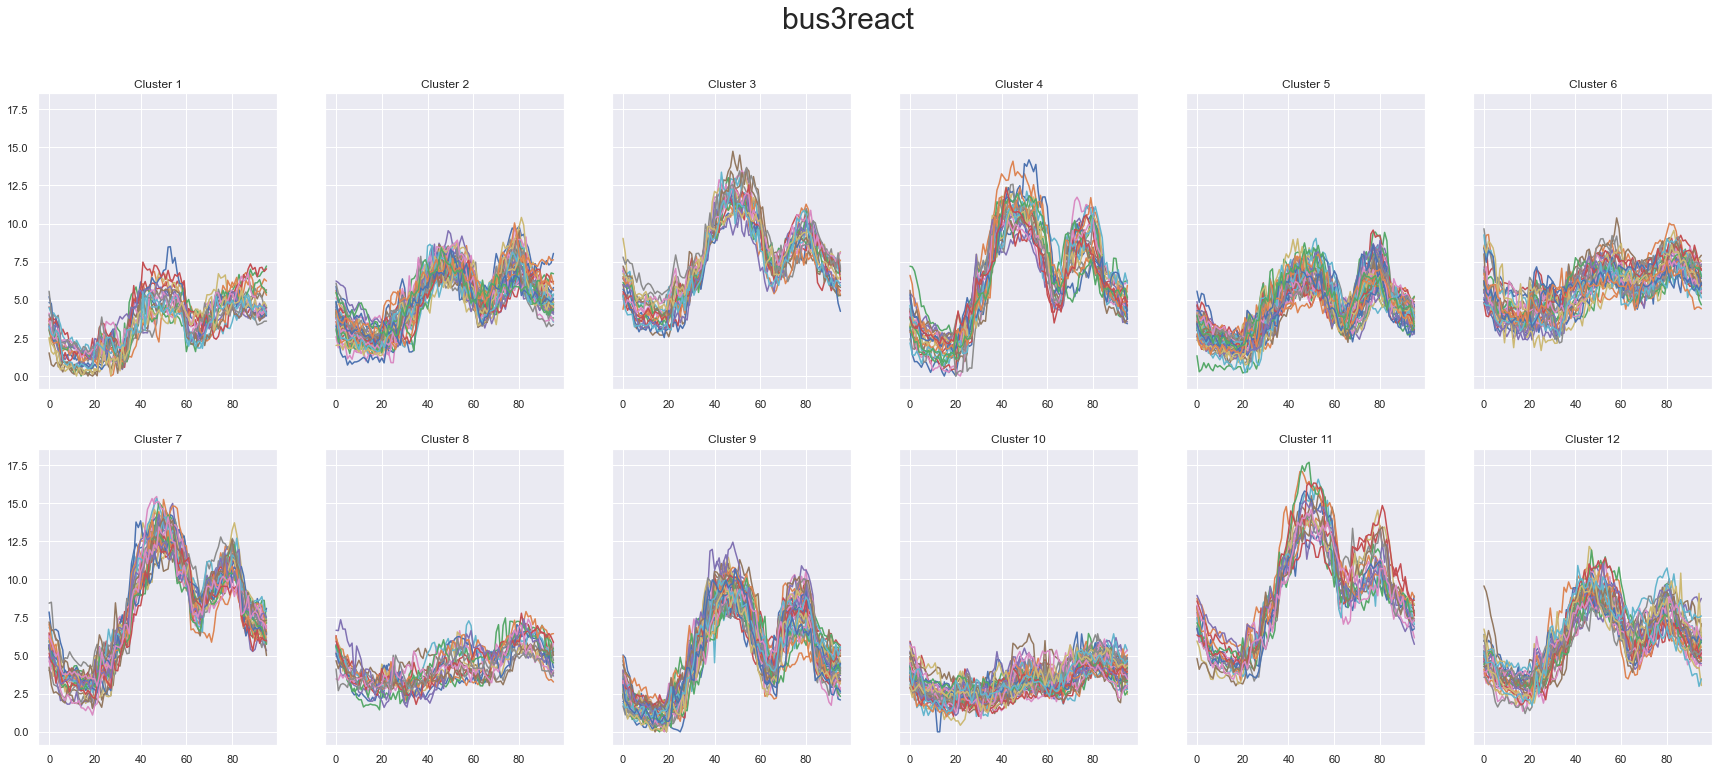

In [11]:
for key in buses.columns:
    Fu.visualization(genbuses_2_3[key], days=365, n_components=12, title = key, visual=True)

# Correlation μεταξύ ζυγών για αρχικά και παραγόμενα δεδομένα

In [12]:
buses.corr()

bus1act  bus1react   bus2act  bus2react   bus3act  bus3react
bus1act    1.000000   0.476512  0.738671   0.372529  0.779243   0.510400
bus1react  0.476512   1.000000 -0.018583   0.402919  0.795657   0.854918
bus2act    0.738671  -0.018583  1.000000   0.509120  0.342800   0.127442
bus2react  0.372529   0.402919  0.509120   1.000000  0.351532   0.497254
bus3act    0.779243   0.795657  0.342800   0.351532  1.000000   0.857527
bus3react  0.510400   0.854918  0.127442   0.497254  0.857527   1.000000

In [15]:
genbuses_2_1.corr()

bus1act  bus1react   bus2act  bus2react   bus3act  bus3react
bus1act    1.000000   0.426050  0.729035   0.352360  0.745279   0.481236
bus1react  0.426050   1.000000 -0.009201   0.379844  0.768942   0.825494
bus2act    0.729035  -0.009201  1.000000   0.478793  0.334627   0.129069
bus2react  0.352360   0.379844  0.478793   1.000000  0.332771   0.477450
bus3act    0.745279   0.768942  0.334627   0.332771  1.000000   0.812493
bus3react  0.481236   0.825494  0.129069   0.477450  0.812493   1.000000

In [14]:
genbuses_2_2.corr()

bus1act  bus1react   bus2act  bus2react   bus3act  bus3react
bus1act    1.000000   0.358050  0.638445   0.255634  0.640091   0.499784
bus1react  0.358050   1.000000 -0.002954   0.323814  0.715812   0.715506
bus2act    0.638445  -0.002954  1.000000   0.334007  0.313530   0.151413
bus2react  0.255634   0.323814  0.334007   1.000000  0.324528   0.406960
bus3act    0.640091   0.715812  0.313530   0.324528  1.000000   0.757364
bus3react  0.499784   0.715506  0.151413   0.406960  0.757364   1.000000

In [13]:
genbuses_2_3.corr()

bus1act  bus1react   bus2act  bus2react   bus3act  bus3react
bus1act    1.000000   0.443119  0.728753   0.360922  0.749570   0.490693
bus1react  0.443119   1.000000 -0.007426   0.395037  0.758519   0.815439
bus2act    0.728753  -0.007426  1.000000   0.483758  0.342869   0.135431
bus2react  0.360922   0.395037  0.483758   1.000000  0.340946   0.491397
bus3act    0.749570   0.758519  0.342869   0.340946  1.000000   0.803999
bus3react  0.490693   0.815439  0.135431   0.491397  0.803999   1.000000

# Ροη Φορτιου για τα αρχικά δεδομένα

In [16]:
import pandapower as pp
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Create the network
net = pp.create_empty_network()

# Step 2: Add buses
ext_grid_bus = pp.create_bus(net, vn_kv=11.0, name="External Grid Bus", bus=0)
bus1 = pp.create_bus(net, vn_kv=11.0, name="Bus 1", bus=1)
bus2 = pp.create_bus(net, vn_kv=11.0, name="Bus 2", bus=2)
bus3 = pp.create_bus(net, vn_kv=11.0, name="Bus 3", bus=3)

ext_grid = pp.create_ext_grid(net, bus=ext_grid_bus, vm_pu = 1)
#gen = pp.create_gen(net, bus=ext_grid_bus, p_mw=1.0, name="Generator")

# Step 3: Add loads
load_data = buses
 
load_df = pd.DataFrame(load_data)

# Step 4: Connect buses and external grid
pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=0.1, std_type="149-AL1/24-ST1A 10.0")
pp.create_line(net, from_bus=bus2, to_bus=bus3, length_km=0.1, std_type="149-AL1/24-ST1A 10.0")
pp.create_line(net, from_bus=bus1, to_bus=bus3, length_km=0.1, std_type="149-AL1/24-ST1A 10.0")
pp.create_line(net, from_bus=ext_grid_bus, to_bus=bus2, length_km=0.1, std_type="149-AL1/24-ST1A 10.0")

load1 = pp.create_load(net, bus=bus1, p_mw=load_df["bus1act"][0], q_mvar=load_df["bus1react"][0], name="load1")
load2 = pp.create_load(net, bus=bus2, p_mw=load_df["bus2act"][0], q_mvar=load_df["bus2react"][0], name="load2")
load3 = pp.create_load(net, bus=bus3, p_mw=load_df["bus3act"][0], q_mvar=load_df["bus3react"][0], name="load3")


voltage_magnitudes = pd.DataFrame(columns=[f"Vbus{i}" for i in range(4)])
voltage_angles = pd.DataFrame(columns=[f"Anglebus{i}" for i in range(4)])
active_power_flows = pd.DataFrame(columns=[f"ActPfl{i}" for i in range(4)])

for i, (_, row) in enumerate(load_df.iterrows()):
    
    net.load['p_mw'] =  [load_df['bus1act'][i], load_df['bus2act'][i], load_df['bus3act'][i]]
    net.load['q_mvar'] = [load_df['bus1react'][i], load_df['bus2react'][i], load_df['bus3react'][i]]
    
    # Run power flow analysis for the current iteration
    pp.runpp(net, algorithm="nr", calculate_voltage_angles=True, max_iteration=100)

    # Step 6: Analyze the results
    voltage_magnitudes.loc[i] = list(net.res_bus.vm_pu[:4])
    voltage_angles.loc[i] = list(net.res_bus.va_degree[:4])
    #active_power_flows.loc[i] = list(net.res_line.p_from_mw[:4])
    #reactive_power_flows = net.res_line.q_from_mvar
    if i == 365*1000:
        break 

Αποτελέσματα μελέτης ροών φορτίου

In [17]:
voltage_magnitudes

Vbus0     Vbus1     Vbus2     Vbus3
0        1.0  0.969117  0.975702  0.970240
1        1.0  0.969898  0.976068  0.970965
2        1.0  0.969991  0.976048  0.970958
3        1.0  0.971838  0.977579  0.972646
4        1.0  0.976453  0.981721  0.977399
...      ...       ...       ...       ...
35035    1.0  0.966297  0.973845  0.968209
35036    1.0  0.965553  0.973453  0.967620
35037    1.0  0.964206  0.972613  0.966102
35038    1.0  0.966306  0.974453  0.968278
35039    1.0  0.969007  0.976486  0.971084

[35040 rows x 4 columns]

In [18]:
voltage_angles

Anglebus0  Anglebus1  Anglebus2  Anglebus3
0            0.0  -2.283178  -1.768059  -2.166290
1            0.0  -2.174471  -1.699223  -2.057991
2            0.0  -2.194261  -1.726782  -2.085950
3            0.0  -2.078765  -1.631865  -1.980848
4            0.0  -1.744792  -1.328490  -1.641280
...          ...        ...        ...        ...
35035        0.0  -2.505235  -1.925335  -2.345423
35036        0.0  -2.527487  -1.924758  -2.354960
35037        0.0  -2.625625  -1.990962  -2.476418
35038        0.0  -2.529172  -1.896785  -2.375033
35039        0.0  -2.294441  -1.720798  -2.118559

[35040 rows x 4 columns]